In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
%matplotlib inline
from scipy.stats import norm, skew

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train.shape

(1460, 81)

In [5]:
test.shape
# test no sales price 

(1459, 80)

In [6]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# All Numerical data -- SOME SHOULD BE CATERGORIAL COLUMNS  
train_num = train.select_dtypes(exclude=['object']).columns
train_num

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [8]:
train.describe()
# with missing data

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [9]:
# Find correlationship among numerical dataset 
train_num_corr = train[train_num].drop(['Id'],axis =1)
corr = pd.DataFrame(train_num_corr.corr(method = 'pearson')['SalePrice'])
corr.sort_values(['SalePrice'],ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [10]:
corr = pd.DataFrame(train_num_corr.corr(method = 'spearman')['SalePrice'])
corr.sort_values(['SalePrice'],ascending = False)

,SalePrice
SalePrice,1.000000
OverallQual,0.809829
GrLivArea,0.731310
GarageCars,0.690711
YearBuilt,0.652682
GarageArea,0.649379
FullBath,0.635957
TotalBsmtSF,0.602725
GarageYrBlt,0.593788
1stFlrSF,0.575408


In [11]:
# Not sure what relationsiop among them... checked linear correlationship and non-linean 
# but these variables are highly correlated with SalePrice

# OverallQual
# GrLivArea
# GarageCars
# GarageArea
# TotalBsmtSF
# 1stFlrSF
# FullBath
# TotRmsAbvGrd
# YearBuilt
# YearRemodAdd
# GarageYrBlt
# MasVnrArea
# Fireplaces
# OpenPorchSF
# LotArea
# MasVnrArea
# LotFrontage

In [12]:
# should know those numerical relationship --- cause they might inner correlated  
sns.set()

cols =['OverallQual',
'GrLivArea',
'GarageCars',
'GarageArea',
'TotalBsmtSF',
'1stFlrSF',
'FullBath',
'TotRmsAbvGrd',
'YearBuilt',
'YearRemodAdd',
'GarageYrBlt',
'MasVnrArea',
'Fireplaces',
'OpenPorchSF',
'LotArea',
'MasVnrArea',
'LotFrontage']


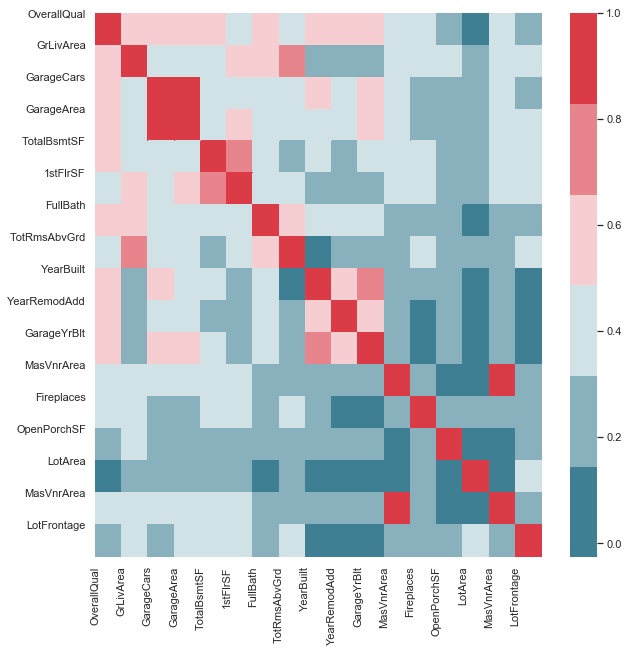

In [13]:
corr = train[cols].corr()
fig, ax = plt.subplots(figsize = (10,10))
colormap = sns.diverging_palette(220, 10, as_cmap=False)
sns.heatmap(corr, cmap=colormap, fmt=".2f")
# sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

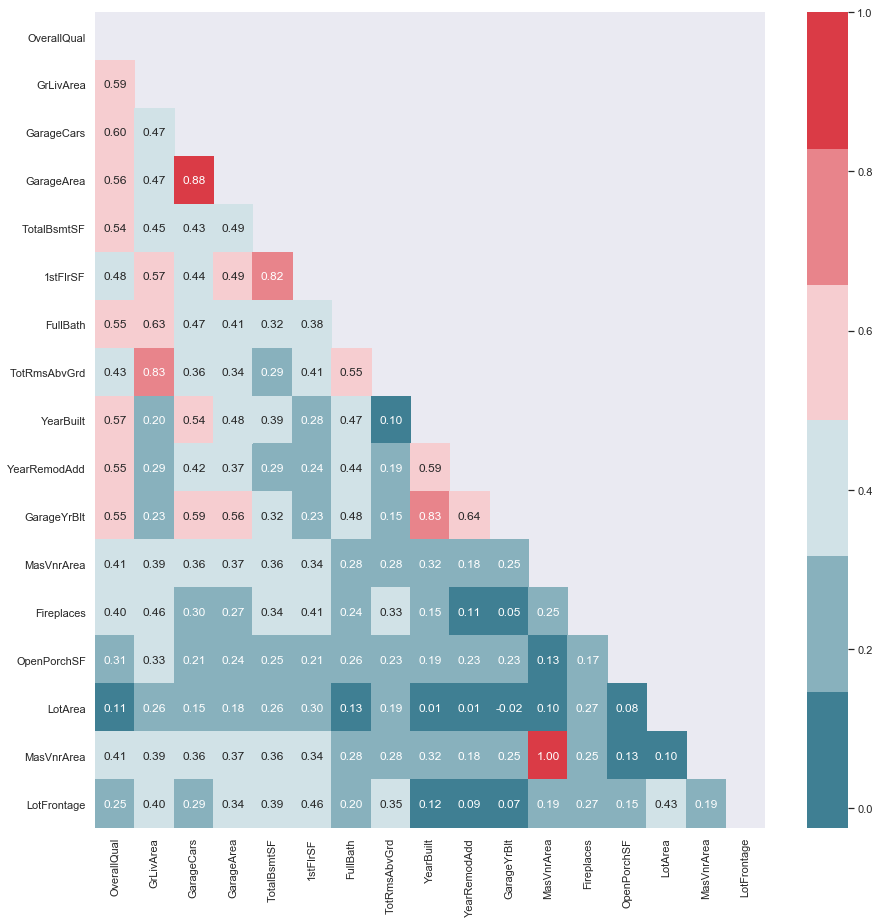

In [14]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap=colormap, annot = True,fmt=".2f", mask=mask)

In [15]:
# some features are inn-related with each other -- then delete them 
# Garage Area, Garage Yer Built, Garage cars ,
# Then decided the numerical features need to be added 

In [16]:
new_cols =['OverallQual',
'TotalBsmtSF',
'1stFlrSF',
'FullBath',
'TotRmsAbvGrd',
'YearBuilt',
'YearRemodAdd',
'MasVnrArea',
'Fireplaces',
'OpenPorchSF',
'LotArea',
'MasVnrArea',
'LotFrontage']

In [17]:
# Categorical Variables
train_cat = train.select_dtypes(include =['object']).columns
train_cat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

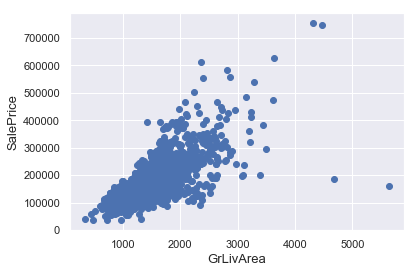

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

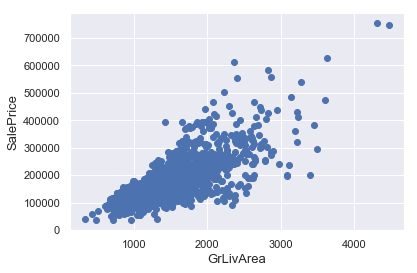

In [19]:
# these two values are outliers.. not follow the regression 
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice'] < 300000)].index)
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

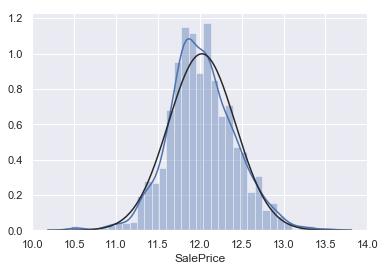

In [20]:
# log-transformation of the "SalePrice"
train['SalePrice'] = np.log1p(train['SalePrice'])      
sns.distplot(train['SalePrice'], fit=norm)

In [21]:
ntrain = train.shape[0]

In [22]:
ntrain

1458

In [23]:
ntest = test.shape[0]

In [24]:
ntest

1459

In [25]:
y_train = train.SalePrice.values

In [26]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [27]:
all_data = pd.concat((train,test)).reset_index (drop = True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [28]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [29]:
all_data.shape

(2917, 81)

In [30]:
# use one hot encoder to deal with catergorial data 
# some numerical number should be the catergoricla number ... 

# from sklearn.preprocessing import OneHotEncoder
# onehotencoder = OneHotEncoder(categorical_features = [0])
# x = onehotencoder.fit_transform(x).toarray()

In [31]:
# Dealing with Missing data 

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
SalePrice,50.017141
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806


In [32]:
# imputing missing data
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

In [33]:
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
# all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
#     lambda x: x.fillna(x.median()))

In [34]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

In [35]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [36]:
# for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
#     all_data[col] = all_data[col].fillna(0)

In [37]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [38]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
# all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [39]:
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [40]:
# all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
# all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
# all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
# all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [41]:
# all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [42]:
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [43]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(30)

,Missing Ratio
LotFrontage,16.660953
MSZoning,0.137127
BsmtHalfBath,0.068564
BsmtFullBath,0.068564
TotalBsmtSF,0.034282
SaleType,0.034282
KitchenQual,0.034282
Exterior2nd,0.034282
Exterior1st,0.034282
Electrical,0.034282


In [44]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


In [45]:
all_data.shape

(2917, 79)

In [46]:
all_data_cat = all_data.select_dtypes(include =['object']).columns
all_data_cat

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood',
       'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition',
       'SaleType', 'Street'],
      dtype='object')

In [47]:
for c in all_data_cat:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

In [48]:
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 79)


In [49]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

In [50]:
numeric_feats

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [51]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
Condition2,12.340989
LowQualFinSF,12.084539
Heating,12.074570
3SsnPorch,11.372080
RoofMatl,8.722755
MiscFeature,5.062388
LandSlope,4.973254


In [52]:
# do not know how to deal with Skewed data  

In [53]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 79)

In [54]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [86]:
train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,1,3,0,4,3,706.0,0.0,...,4,8,0,1,8,856.0,0,2003,2003,2008
1,1262,0,0,1,3,0,4,1,978.0,0.0,...,4,8,0,1,6,1262.0,298,1976,1976,2007
2,920,866,0,1,3,0,4,2,486.0,0.0,...,4,8,0,1,6,920.0,0,2001,2002,2008
3,961,756,0,1,3,0,1,3,216.0,0.0,...,0,8,0,1,7,756.0,0,1915,1970,2006
4,1145,1053,0,1,4,0,4,0,655.0,0.0,...,4,8,0,1,9,1145.0,192,2000,2000,2008


In [57]:
my_model = XGBRegressor(n_estimators=500,learning_rate= 0.05)
my_model.fit(train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [72]:
my_pipeline = Pipeline(steps = [
  ('model', my_model)
])

In [73]:
train_pred = my_pipeline.predict(train)

In [74]:
train_pred

array([12.2407055, 12.068295 , 12.245172 , ..., 12.481884 , 11.846194 ,
       11.902271 ], dtype=float32)

In [75]:
RMSE = sqrt(mean_squared_error(y_train,train_pred))

In [77]:
RMSE


0.06447852497628835

In [78]:
test_pred = my_pipeline.predict(test)

In [79]:
test_pred

array([11.727048, 11.973377, 12.131517, ..., 11.954223, 11.613435,
       12.311747], dtype=float32)

In [88]:
Actual_Pred = [np.exp(x)-1 for x in test_pred]
Actual_Pred

[123876.4375,
 158477.984375,
 185630.234375,
 188729.453125,
 183941.125,
 173801.8125,
 172281.609375,
 162289.28125,
 185008.84375,
 124750.3046875,
 192716.484375,
 85784.7890625,
 90784.9453125,
 150424.5625,
 122640.8828125,
 323357.46875,
 224769.890625,
 256815.640625,
 240426.046875,
 530536.75,
 311192.28125,
 186558.078125,
 149118.5,
 155427.828125,
 169441.984375,
 187741.21875,
 334976.90625,
 218051.453125,
 179880.1875,
 191103.53125,
 189724.515625,
 85393.7265625,
 175914.125,
 306105.71875,
 310515.1875,
 234886.125,
 182981.28125,
 150340.515625,
 148240.234375,
 132365.796875,
 166752.03125,
 142535.234375,
 267438.78125,
 237980.140625,
 225544.625,
 188419.59375,
 252598.109375,
 196817.03125,
 168036.328125,
 146832.796875,
 144318.1875,
 167032.46875,
 139383.109375,
 149742.25,
 190325.265625,
 152662.625,
 156482.03125,
 138804.234375,
 213152.078125,
 135196.921875,
 135212.140625,
 174342.0,
 109213.1171875,
 119945.984375,
 122360.3828125,
 120491.953125,


In [81]:
House_id = test["Id"]

In [89]:
test["SalePrice"] = Actual_Pred
test['Id'] = House_id

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [90]:
final_data = test[['Id','SalePrice']]

In [91]:
final_data.to_csv("Hourse price Prediction_6.csv" ,index = False)